In [ ]:
import os
import numpy as np

from eswl.tools import deserialize
from eswl.tools import plotTF
from eswl import tools

from scipy.sparse.linalg import eigs
from scipy.linalg import svd

import matplotlib.pyplot as plt
import json

cmp = plt.rcParams['axes.prop_cycle'].by_key()['color']

# File paths for saving/loading data and results
data_path = os.path.join(os.getcwd(), 'data')
simres_file = os.path.join(data_path, 'SimResults.json')

In [ ]:
# Load simulation results
if not os.path.exists(simres_file):
    raise FileNotFoundError(
        f"{simres_file} not found. Generate simulation results using script main0.py."
    )
else:
    with open(simres_file, 'r') as json_file:
        data = deserialize ( json.load(json_file) )
        results = data['results']
        ESWLresults = data['ESWLresults']
        modalInfo = data['modalInfo']
        nodalInfo = data['nodalInfo']
        time = data['time']
        drag_forces = data['drag_forces']
        structuralModel = data['structuralModel']
        windModel = data['windModel']
        aeroSec = data['aeroSec']        

# Access structural model details
XNOD = structuralModel['XNOD']
iDOF_obs = structuralModel['iDOF_obs']-1  # Convert to 1D array
iDOF_obs = np.array(iDOF_obs).flatten()
iDOF_obs = iDOF_obs[[1, 3, 5]]

# Define index arrays
i_x = np.arange(0, 170, 2) # keep only x-displacements
i_m = np.arange(170, 255)

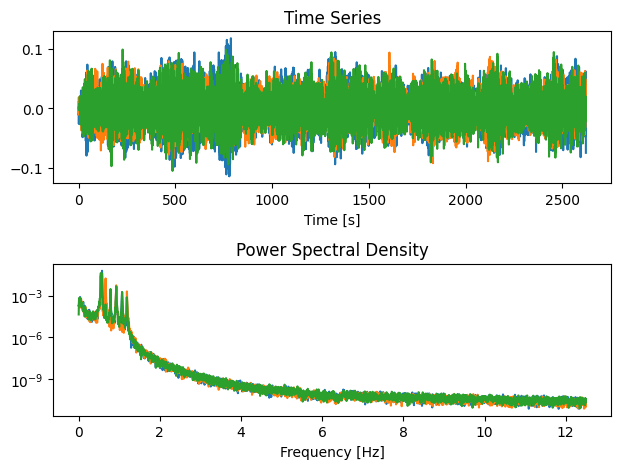

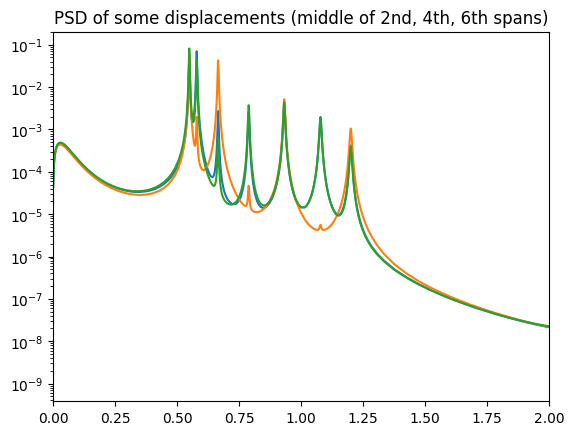

In [3]:
# Plot PSD of some responses
plotTF(time, ESWLresults['z'][iDOF_obs, :].T, 2048 * 4)

# Plot stochastic spectral analysis for comparison
plt.figure()
for i in iDOF_obs:
    plt.semilogy(nodalInfo['f_stoch'].flatten(), np.squeeze(nodalInfo['Sx'][i, i, :].real))
    plt.xlim([0, 2])
    plt.hold = True  # Equivalent to MATLAB's `hold on`
plt.title('PSD of some displacements (middle of 2nd, 4th, 6th spans)')
plt.show()

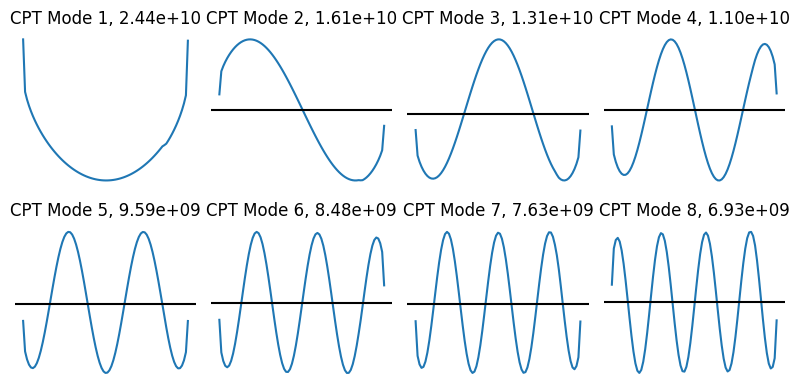

In [18]:
# Compute eigenmodes (CPT modes)
# Assuming nodal_cov_f is a NumPy array (dense), else use eigs for sparse
Df, Vf = eigs(results['nodal']['cov_f'], k=8)  # Df will be a diag matrix of eigenvalues
Vf = Vf.real  # Ensure eigenvectors are real

# Plot eigenvectors (modes)
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(8, 4))
for i in range(8):
    axs[i // 4, i % 4].plot(Vf[:, i])
    axs[i // 4, i % 4].axis('tight')
    axs[i // 4, i % 4].axis('off')
    axs[i // 4, i % 4].set_title(f"CPT Mode {i+1}, {Df[i].real:.2e}")
    axs[i // 4, i % 4].axhline(0, color='k')

plt.tight_layout()
plt.show()

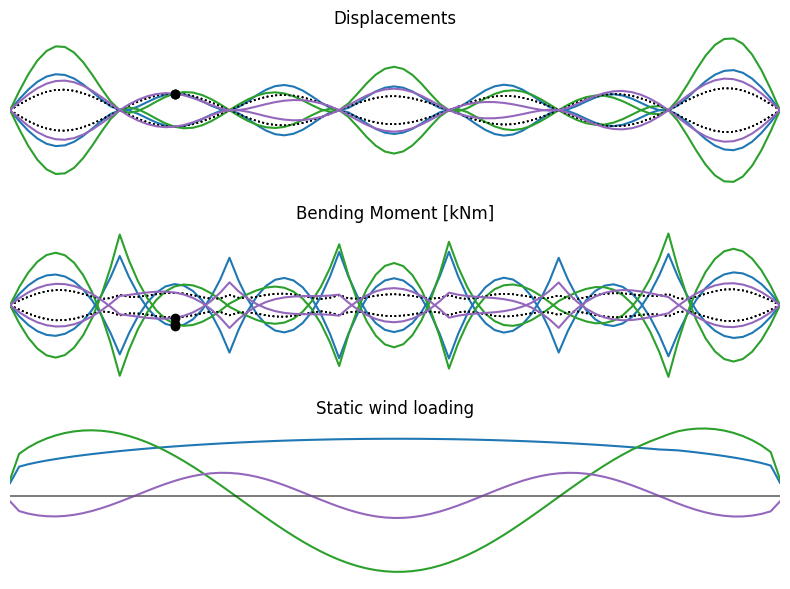

In [33]:
fig, ax = plt.subplots(3, 1, figsize=(8, 6))

for imode in [0, 2, 4]:
    i_z = iDOF_obs[0]  # second element (index 1)

    eswl = np.zeros((len(i_x), i_z+1))
    eswl[:, i_z] = Vf[:, imode].real  # or .imag if needed

    clr = cmp[imode]  # assuming cmp is a color map as a 2D array

    tools.plot_diagrams(ESWLresults, structuralModel, i_x, i_m, [i_z], clr, eswl, ax=ax)

0
1
2


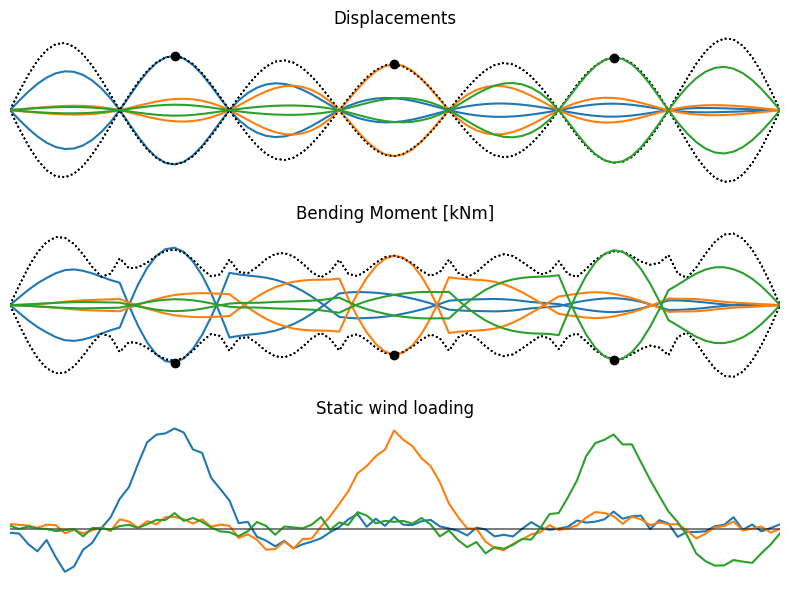

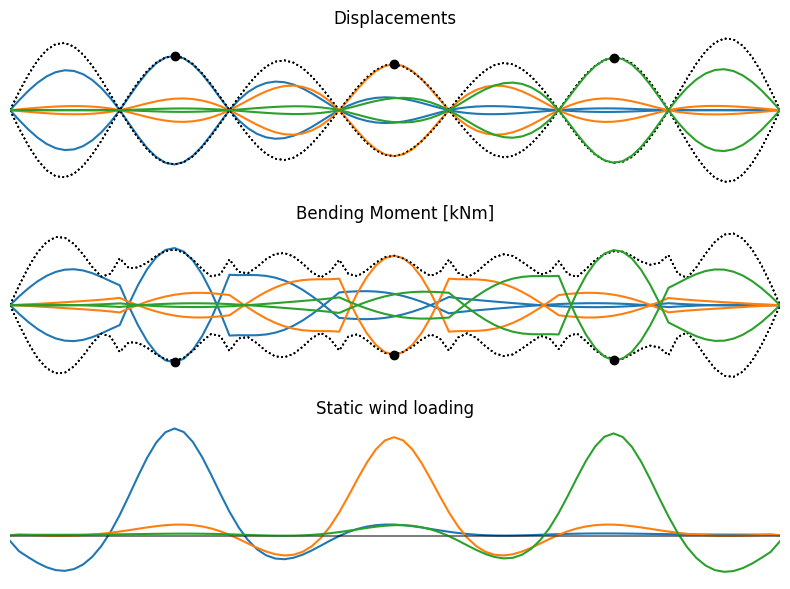

In [35]:
## LRC - Displacements
f_LRC = np.zeros((len(structuralModel['corres']), len(iDOF_obs)))
x_reconstruct = np.zeros_like(f_LRC)

# From time series
fig, ax = plt.subplots(3, 1, figsize=(8, 6))
enveloppe = np.std(ESWLresults['z'][0:170:2, :], axis=1)

for i, dof in enumerate(iDOF_obs):
    cov_xf = ESWLresults['z'][dof, :] @ drag_forces / 65536
    std_x = np.std(ESWLresults['z'][dof, :])

    f_LRC[structuralModel['loadedDOFs'], i] = cov_xf / std_x
    x_reconstruct[:, i] = np.linalg.solve(structuralModel['K'], f_LRC[:, i])

    scale = x_reconstruct[dof, i] / std_x
    f_LRC[structuralModel['loadedDOFs'], i] /= scale
    x_reconstruct[:, i] /= scale

# Plot (time series)
eswl = np.zeros((len(i_x), np.max(iDOF_obs)+1)) # will be several zeros in this matrix

for i, dof in enumerate(iDOF_obs):
    print(i)
    i_z = dof
    eswl[:, i_z] = f_LRC[0::2, i]
    clr = cmp[i]
    tools.plot_diagrams(ESWLresults, structuralModel, i_x, i_m, [i_z], clr, eswl, ax=ax)

# From spectral analysis
enveloppe = results['nodal']['std_x'][0::2]
for i, dof in enumerate(iDOF_obs):
    cov_xf = results['nodal']['cov_xf'][dof, :]
    std_x = results['nodal']['std_x'][dof]

    f_LRC[structuralModel['loadedDOFs'], i] = cov_xf / std_x
    x_reconstruct[:, i] = np.linalg.solve(structuralModel['K'], f_LRC[:, i])

    scale = x_reconstruct[dof, i] / std_x
    f_LRC[structuralModel['loadedDOFs'], i] /= scale
    x_reconstruct[:, i] /= scale

# Plot (spectral)
fig, ax = plt.subplots(3, 1, figsize=(8, 6))
for i, dof in enumerate(iDOF_obs):
    i_z = dof
    eswl[:, i_z] = f_LRC[0::2, i]
    clr = cmp[i]
    tools.plot_diagrams(ESWLresults, structuralModel, i_x, i_m, [i_z], clr, eswl, ax=ax)

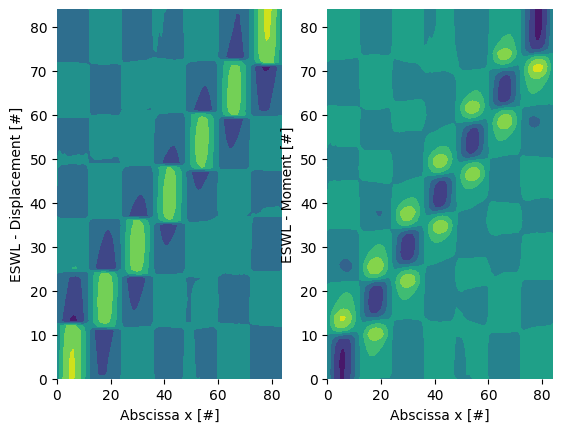

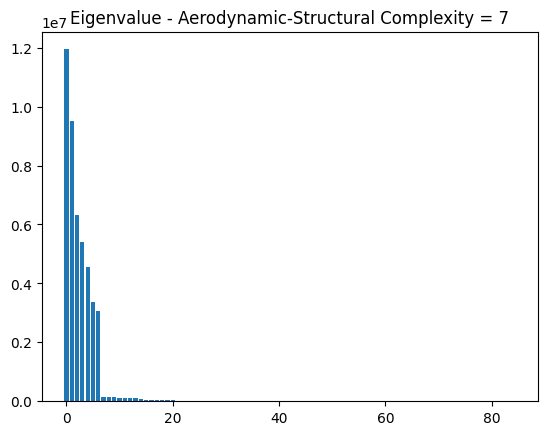

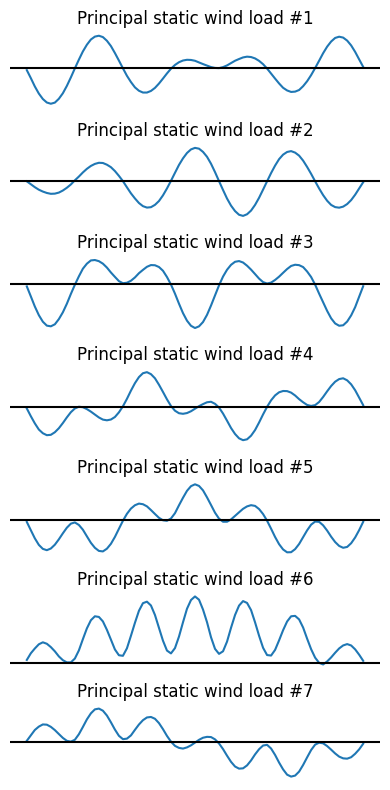

In [37]:
# PSWL
eswl = ESWLresults['ESWL'][:, :, 1]  # MATLAB index 2 -> Python index 1

# Compensate for NaN in the last column (moment on support)
eswl[:, -1] = 2 * eswl[:, -2] - eswl[:, -3]

plt.figure()

# First subplot: Displacement
plt.subplot(1, 2, 1)
plt.contourf(eswl[:, i_x].T)
plt.axis('tight')
plt.box(False)
plt.xlabel('Abscissa x [#]')
plt.ylabel('ESWL - Displacement [#]')

# Second subplot: Moment
plt.subplot(1, 2, 2)
plt.contourf(eswl[:, i_m].T)
plt.axis('tight')
plt.box(False)
plt.xlabel('Abscissa x [#]')
plt.ylabel('ESWL - Moment [#]')

# SVD
U, S, Vh = svd(eswl, full_matrices=False)

plt.figure()
plt.bar(np.arange(len(S)), S)
plt.title('Eigenvalue - Aerodynamic-Structural Complexity = 7')

ASC = 7
plt.figure(figsize=(4, 8))

for i in range(ASC):
    plt.subplot(ASC, 1, i + 1)
    plt.plot(U[:, i])
    plt.axis('tight')
    plt.axhline(0, color='k')
    plt.axis('off')
    plt.title(f'Principal static wind load #{i + 1}')
    plt.tight_layout()

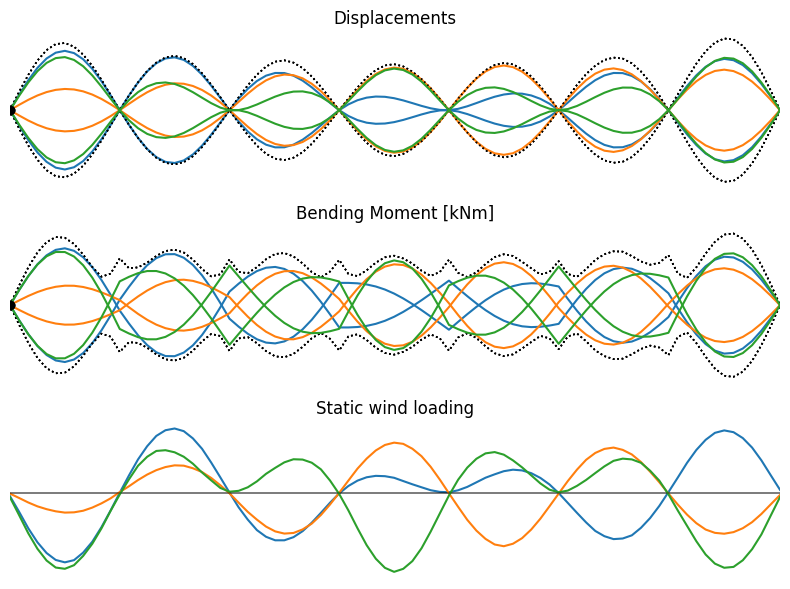

In [38]:

i_z = 0

x_rec = np.zeros((len(i_x), 3))
m_rec = np.zeros((len(i_m), 3))

fig, ax = plt.subplots(3, 1, figsize=(8, 6))
for i_pswl in range(3):
    iclr = i_pswl
    if iclr > 6:
        iclr -= 7
    clr = cmp[iclr]
    x_rec[:, [i_pswl]], m_rec[:, i_pswl], scale = tools.plot_diagrams(
        ESWLresults, structuralModel, i_x, i_m, [i_z], clr, U[:, [i_pswl]], fit_env_scale=True, ax=ax
    )

x_env = np.max(np.abs(x_rec), axis=1)
m_env = np.max(np.abs(m_rec), axis=1)

<Figure size 640x480 with 0 Axes>

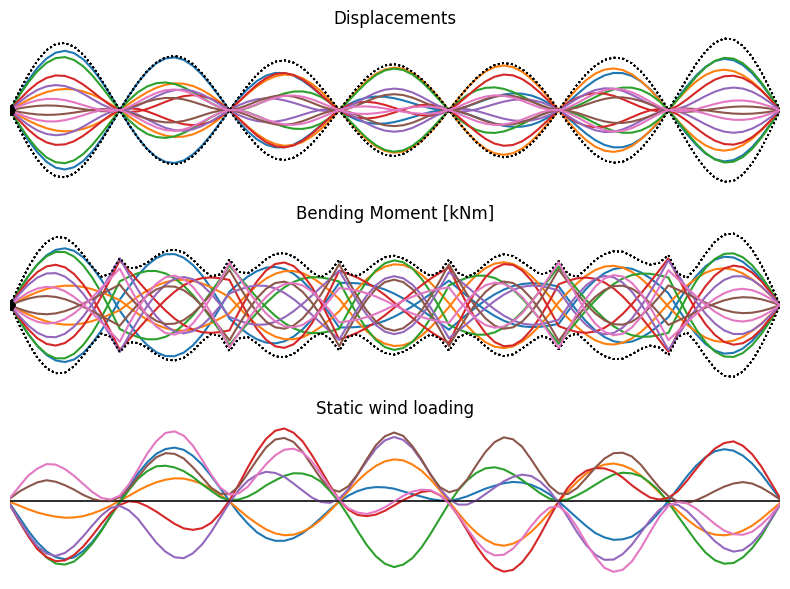

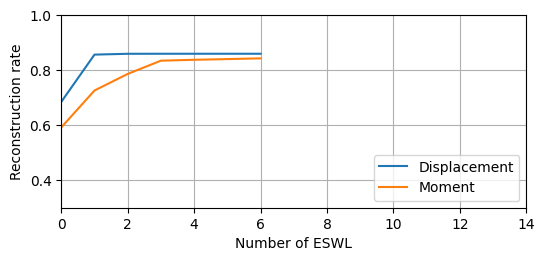

In [46]:
# Define metrics to quantify the envelope reconstruction rate
metric_x = np.sum(np.abs(ESWLresults['z_max'][i_x]))
metric_m = np.sum(np.abs(ESWLresults['z_max'][i_m]))

# Prepare convergence plot
fig = plt.figure()
target_x = np.abs(ESWLresults['z_max'][i_x])
target_m = np.abs(ESWLresults['z_max'][i_m])
i_z = 0

x_rec = np.zeros((len(i_x), ASC))
m_rec = np.zeros((len(i_m), ASC))
reconst_rate = np.zeros((ASC, 2))

fig, ax = plt.subplots(3, 1, figsize=(8, 6))
for i_pswl in range(ASC):
    
    iclr = i_pswl
    if iclr >= len(cmp):
        iclr -= len(cmp)
    clr = cmp[iclr]
    
    x_tmp, m_tmp, _ = tools.plot_diagrams(
        ESWLresults, structuralModel, i_x, i_m, [i_z], clr, U[:, [i_pswl]], fit_env_scale=True, ax=ax
    )

    # Make sure returned shapes are column-wise
    x_tmp = x_tmp.flatten()
    m_tmp = m_tmp.flatten()

    x_rec[:, i_pswl] = x_tmp
    m_rec[:, i_pswl] = m_tmp

    x_env = np.max(np.column_stack([x_rec, -x_rec]), axis=1)
    m_env = np.max(np.column_stack([m_rec, -m_rec]), axis=1)

    # Clamp envelope values to target
    x_env_tmp = np.copy(x_env)
    m_env_tmp = np.copy(m_env)
    x_env_tmp[x_env > target_x] = target_x[x_env > target_x]
    m_env_tmp[m_env > target_m] = target_m[m_env > target_m]

    reconst_rate[i_pswl, 0] = np.sum(x_env_tmp) / metric_x
    reconst_rate[i_pswl, 1] = np.sum(m_env_tmp) / metric_m

# Final plot of reconstruction rate
plt.figure()
plt.plot(reconst_rate)
plt.grid(True)
plt.ylim([0.3, 1])
plt.xlim([0, 14])
plt.gcf().set_size_inches(6, 2.5)
plt.xlabel('Number of ESWL')
plt.ylabel('Reconstruction rate')
plt.legend(['Displacement', 'Moment'], loc='lower right')
plt.show()


/Users/vincentdenoel/Dropbox/001_ULg/004_Publis_Conf/02_journal_papers/102_ICWE-Keynote_EnvReconstruction/python code/eswl/tools.py:120: RuntimeWarning: divide by zero encountered in divide
  scale_m = np.min(np.abs(upper[i_m[:-1]] / Bendi[:, 0]))


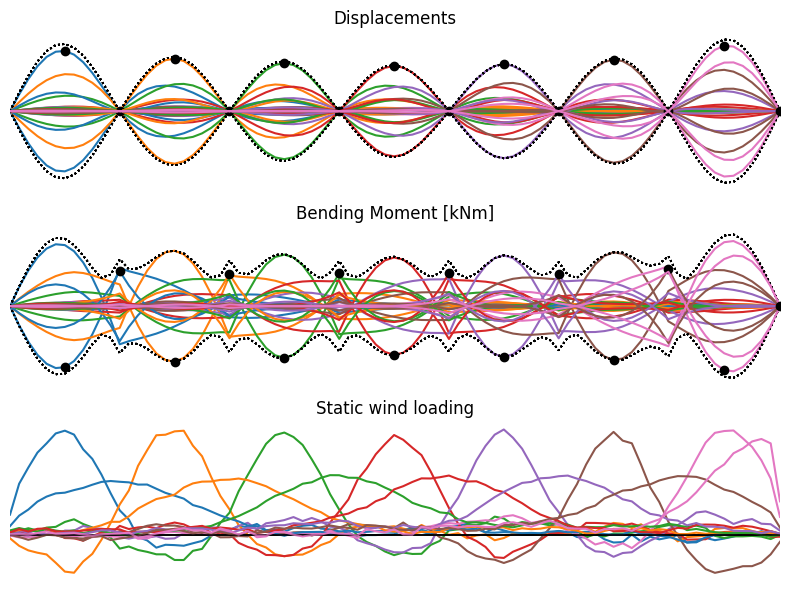

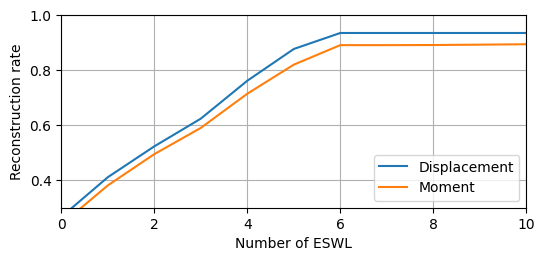

In [54]:
# Naive reconstruction of ESWL

target_x = np.abs(ESWLresults['z_max'][i_x])
target_m = np.abs(ESWLresults['z_max'][i_m])

eswl = ESWLresults['ESWL'][:, :, 2]  # shape (n_dof, n_cases)

x_rec = np.zeros((len(i_x), 14))
m_rec = np.zeros((len(i_m), 14))
reconst_rate = np.zeros((14, 2))

iDOF_obs = structuralModel['iDOF_obs'].flatten()-1  # Convert to 1D array

fig, ax = plt.subplots(3, 1, figsize=(8, 6))

for icas in range(14):
    iclr = icas % 7  # wrap color index

    if icas < 7:
        i_z = iDOF_obs[icas]
    else:
        i_z = iDOF_obs[icas - 7] + 12

    clr = cmp[iclr]

    x_tmp, m_tmp, _ = tools.plot_diagrams(ESWLresults, structuralModel, i_x, i_m, [i_z], clr, eswl, fit_env_scale=True, ax=ax)
    x_tmp = x_tmp.flatten()
    m_tmp = m_tmp.flatten()

    x_rec[:, icas] = x_tmp
    m_rec[:, icas] = m_tmp

    x_env = np.max(np.column_stack([x_rec, -x_rec]), axis=1)
    m_env = np.max(np.column_stack([m_rec, -m_rec]), axis=1)

    x_env_tmp = np.minimum(x_env, target_x)
    m_env_tmp = np.minimum(m_env, target_m)

    reconst_rate[icas, 0] = np.sum(x_env_tmp) / np.sum(target_x)
    reconst_rate[icas, 1] = np.sum(m_env_tmp) / np.sum(target_m)

plt.figure(999)
plt.plot(reconst_rate)
plt.grid(True)
plt.ylim([0.3, 1])
plt.xlim([0, 10])
plt.gcf().set_size_inches(6, 2.5)
plt.xlabel('Number of ESWL')
plt.ylabel('Reconstruction rate')
plt.legend(['Displacement', 'Moment'], loc='lower right')
plt.show()


<Figure size 640x480 with 0 Axes>

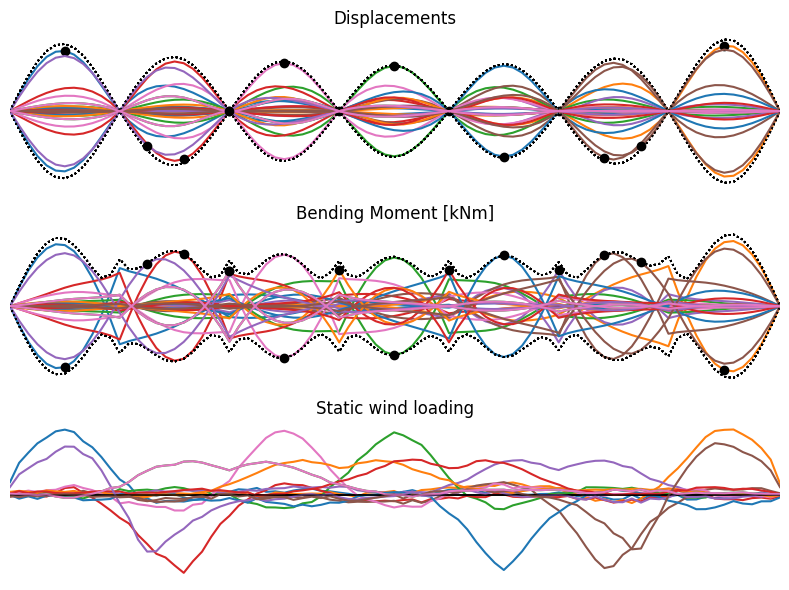

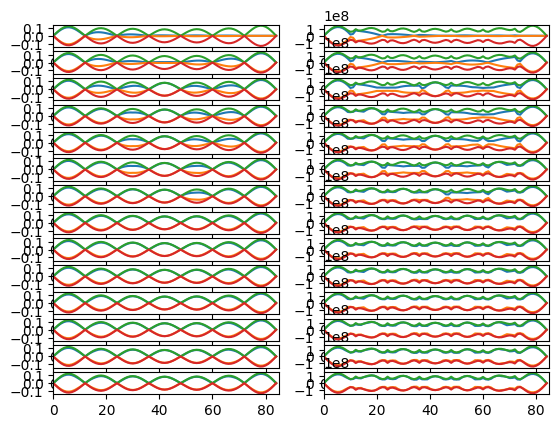

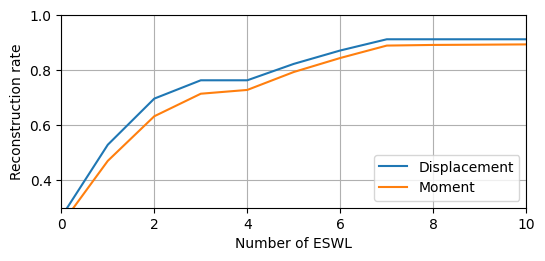

<Figure size 640x480 with 0 Axes>

In [63]:
# Fastest descent method for ESWL reconstruction

fig = plt.figure()
x_rec = np.zeros((len(i_x), 14))
m_rec = np.zeros((len(i_m), 14))
reconst_rate = np.zeros((14, 2))

sub1 = []
sub2 = []

iDOF_obs = structuralModel['iDOF_obs'].flatten()-1  # Convert to 1D array
i_z = iDOF_obs[0]  # start point

fig, ax = plt.subplots(3, 1, figsize=(8, 6))

for icas in range(14):
    plt.figure(fig.number)
    iclr = icas % 7
    clr = cmp[iclr]

    x_tmp, m_tmp, _ = tools.plot_diagrams(ESWLresults, structuralModel, i_x, i_m, [i_z], clr, eswl, fit_env_scale=True, ax=ax)
    x_tmp = x_tmp.flatten()
    m_tmp = m_tmp.flatten()

    x_rec[:, icas] = x_tmp
    m_rec[:, icas] = m_tmp

    x_env = np.max(np.column_stack([x_rec, -x_rec]), axis=1)
    m_env = np.max(np.column_stack([m_rec, -m_rec]), axis=1)

    x_env_tmp = np.minimum(x_env, target_x)
    m_env_tmp = np.minimum(m_env, target_m)

    reconst_rate[icas, 0] = np.sum(x_env_tmp) / np.sum(target_x)
    reconst_rate[icas, 1] = np.sum(m_env_tmp) / np.sum(target_m)

    # Choose next i_z based on largest reconstruction gap
    i_xx = np.argmax(target_x - x_env_tmp)
    i_mm = np.argmax(target_m - m_env_tmp)

    if (target_x[i_xx] - x_env_tmp[i_xx]) / np.sum(target_x) > (target_m[i_mm] - m_env_tmp[i_mm]) / np.sum(target_m):
        i_z = 2 * i_xx
    else:
        i_z = 170 + i_mm


    # Subplot diagnostics
    plt.figure(101)
    ax1 = plt.subplot(14, 2, 2 * icas + 1)
    ax1.plot(x_env, label="x_env")
    ax1.plot(-x_env)
    ax1.plot(np.abs(target_x))
    ax1.plot(-np.abs(target_x))
    ax1.set_xlim([0, len(x_env)])
    sub1.append(ax1)

    ax2 = plt.subplot(14, 2, 2 * icas + 2)
    ax2.plot(m_env, label="m_env")
    ax2.plot(-m_env)
    ax2.plot(np.abs(target_m))
    ax2.plot(-np.abs(target_m))
    ax2.set_xlim([0, len(m_env)])
    sub2.append(ax2)


plt.figure(999)
plt.plot(reconst_rate)
plt.grid(True)
plt.ylim([0.3, 1])
plt.xlim([0, 10])
plt.gcf().set_size_inches(6, 2.5)
plt.xlabel('Number of ESWL')
plt.ylabel('Reconstruction rate')
plt.legend(['Displacement', 'Moment'], loc='lower right')
plt.show()


# Align subplot axes and hide them
plt.figure(101)
ax1_limits = list(sub1[-1].get_xlim()) + list(sub1[-1].get_ylim())
ax2_limits = list(sub2[-1].get_xlim()) + list(sub2[-1].get_ylim())

for i in range(14):
    sub1[i].axis(ax1_limits)
    sub1[i].axis('off')
    sub1[i].set_position([0.01, 0.92 - i * 0.07, 0.48, 0.07])

    sub2[i].axis(ax2_limits)
    sub2[i].axis('off')
    sub2[i].set_position([0.51, 0.92 - i * 0.07, 0.48, 0.07])
